# Lab 3 Modeling 
- Read in dataset and split for training and testing
- Define some helper functions 
- Define a model
- Create a set of hyperparameters to experiment through
- Log artifacts into Mlflow 
- Find best model and test prediction

<b>Remember to include your initials</b>

In [ ]:
%loadMlflow

In [ ]:
%Setexp --name <INITIALS HERE>-bike-sharing-use-case

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifact

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.inspection import permutation_importance
from mlflow.models.signature import infer_signature
from sklearn import tree

# from pydotplus import graph_from_dot_data
import graphviz
from IPython.display import Image

import itertools, os

plt.style.use("fivethirtyeight")
pd.plotting.register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')

%store -r STUDENT

In [ ]:
# Project repo path function - file system mount available to all app containers
def ProjectRepo(path):
    ProjectRepo = "/bd-fs-mnt/project_repo"
    return str(ProjectRepo + '/' + path)

# load input data into pandas dataframe
X = pd.read_csv(ProjectRepo("data/" + STUDENT + "_BikeShare/X_clean.csv"))
y = pd.read_csv(ProjectRepo("data/" + STUDENT + "_BikeShare/y_clean.csv"))
y = y.rented_bikes
X.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
# Split the dataset randomly into 70% for training and 30% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42)

print(f"Training samples: {X_train.size}")
print(f"Test samples: {X_test.size}")

## Evaluation Metrics

Create evaluation methods to be used in training stage (next step)

## Root Mean Square Error (RMSE)

References: 
- https://medium.com/@xaviergeerinck/artificial-intelligence-how-to-measure-performance-accuracy-precision-recall-f1-roc-rmse-611d10e4caac
- https://www.kaggle.com/residentmario/model-fit-metrics#Root-mean-squared-error-(RMSE)


In [ ]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def rmse_score(y, y_pred):
    score = rmse(y, y_pred)
    print("RMSE score: {:.4f}".format(score))
    return score

## Cross-Validation RMSLE score

cross-validation combines (averages) measures of fitness in prediction to derive a more accurate estimate of model prediction performance.

Background: 
- https://en.wikipedia.org/wiki/Cross-validation_(statistics)
- https://www.kaggle.com/carlolepelaars/understanding-the-metric-rmsle


In [ ]:
def rmsle_cv(model, X_train, y_train):
    kf = KFold(n_splits=3, shuffle=True, random_state=42).get_n_splits(X_train.values)
    # Evaluate a score by cross-validation
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse


def rmse_cv_score(model, X_train, y_train):
    score = rmsle_cv(model, X_train, y_train)
    print("Cross-Validation RMSE score: {:.4f} (std = {:.4f})".format(score.mean(), score.std()))
    return score

## Feature Importance

Background: https://medium.com/bigdatarepublic/feature-importance-whats-in-a-name-79532e59eea3

In [ ]:
def model_feature_importance(model):
    feature_importance = pd.DataFrame(
        model.feature_importances_,
        index=X_train.columns,
        columns=["Importance"],
    )

    # sort by importance
    feature_importance.sort_values(by="Importance", ascending=False, inplace=True)

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=feature_importance.reset_index(),
        y="index",
        x="Importance",
    ).set_title("Feature Importance")
    # save image
    plt.savefig("model_artifacts/feature_importance.png", bbox_inches='tight')

## Permutation Importance

Background: https://www.kaggle.com/dansbecker/permutation-importance

In [ ]:
def model_permutation_importance(model):
    p_importance = permutation_importance(model, X_test, y_test, random_state=42, n_jobs=-1)

    # sort by importance
    sorted_idx = p_importance.importances_mean.argsort()[::-1]
    p_importance = pd.DataFrame(
        data=p_importance.importances[sorted_idx].T,
        columns=X_train.columns[sorted_idx]
    )

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=p_importance,
        orient="h"
    ).set_title("Permutation Importance")

    # save image
    plt.savefig("model_artifacts/permutation_importance.png", bbox_inches="tight")

## Decision Tree Visualization

Reference: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc 


TODO: plot all trees

In [ ]:
def model_tree_visualization(model):
    # generate visualization
    tree_dot_data = tree.export_graphviz(
        decision_tree=model.estimators_[0, 0],  # Get the first tree,
        label="all",
        feature_names=X_train.columns,
        filled=True,
        rounded=True,
        proportion=True,
        impurity=False,
        precision=1,
    )

    # save image
    graph_from_dot_data(tree_dot_data).write_png("model_artifacts/Decision_Tree_Visualization.png")

    # show tree
    return graphviz.Source(tree_dot_data)

# MLflow Tracking

Reference: https://www.mlflow.org/docs/latest/cli.html#mlflow-ui


## MLflow Logger

In [ ]:
# Track params and metrics
def log_mlflow_run(model, signature):
    # Auto-logging for scikit-learn estimators
    # mlflow.sklearn.autolog()

    # log estimator_name name
    name = model.__class__.__name__
    mlflow.set_tag("estimator_name", name)

    # log input features
    mlflow.set_tag("features", str(X_train.columns.values.tolist()))

    # Log tracked parameters only
    mlflow.log_params({key: model.get_params()[key] for key in parameters})

    mlflow.log_metrics({
        'RMSE_CV': score_cv.mean(),
        'RMSE': score,
    })

    # log training loss
    for s in model.train_score_:
        mlflow.log_metric("Train Loss", s)

    # Save model to artifacts
    mlflow.sklearn.log_model(model, "model", signature=signature)

    # log charts
    mlflow.log_artifacts("model_artifacts")

    # misc
    # Log all model parameters
    mlflow.log_params(model.get_params())
    mlflow.log_param("Training size", X_test.size) 
    mlflow.log_param("Test size", y_test.size)

# Model Training

## Model Type & Method

For this example,
- Approach: Decision tree (Supervised learning)
- Tree type: Regression tree
- Technique/ensemble method: Gradient boosting

**All put together we get:** [GBRT (Gradient Boosted Regression Tree)](https://orbi.uliege.be/bitstream/2268/163521/1/slides.pdf)

Background:
- Choosing a model: https://scikit-learn.org/stable/tutorial/machine_learning_map
- Machine Learning Models Explained
: https://docs.paperspace.com/machine-learning/wiki/machine-learning-models-explained
- Gradient Boosted Regression Trees: https://orbi.uliege.be/bitstream/2268/163521/1/slides.pdf


In [ ]:
# GBRT (Gradient Boosted Regression Tree) scikit-learn implementation 
model_class = GradientBoostingRegressor

## Model Hyper-parameters 

In [ ]:
parameters = {
    "learning_rate": [0.1, 0.05, 0.01],
    "max_depth": [4, 5, 6],
    # "verbose": True,
}

## Tuning the hyper-parameters: Grid search

- Simple but inefficient
- more advanced tuning techniques: https://research.fb.com/efficient-tuning-of-online-systems-using-bayesian-optimization/

In [ ]:
# generate parameters combinations
params_keys = parameters.keys()
params_values = [
    parameters[key] if isinstance(parameters[key], list) else [parameters[key]]
    for key in params_keys
]
runs_parameters = [
    dict(zip(params_keys, combination)) for combination in itertools.product(*params_values)
]

The following snippet of code will faciliate the the training and tracking of each metric into MLflow. <br>
We will iterate through various combinations of the hyper parameters set above. <br>
Each iteration of the loop will generate artifacts which will be stored in the "model_artifacts" folder, where Mlflow will copy and save it into their respective runs. 

In [ ]:
# training loop
for i, run_parameters in enumerate(runs_parameters):
    print(f"Run {i}: {run_parameters}")

    # mlflow: stop active runs if any
    if mlflow.active_run():
        mlflow.end_run()
    # mlflow:track run
    mlflow.start_run(run_name=f"Run {i}")

    # create model instance
    model = model_class(**run_parameters)

    # train
    model.fit(X_train, y_train)

    # get evaluations scores
    score = rmse_score(y_test, model.predict(X_test))
    score_cv = rmse_cv_score(model, X_train, y_train)
    
    # generate charts
    model_feature_importance(model)
    plt.close()
    model_permutation_importance(model)
    plt.close()
#     model_tree_visualization(model)

    # get model signature
    signature = infer_signature(model_input=X_train, model_output=model.predict(X_train))

    # mlflow: log metrics
    log_mlflow_run(model, signature)

    # mlflow: end tracking
    mlflow.end_run()
    print("")

## Navigate to your MLflow server endpoint and view the runs of your experiments. 
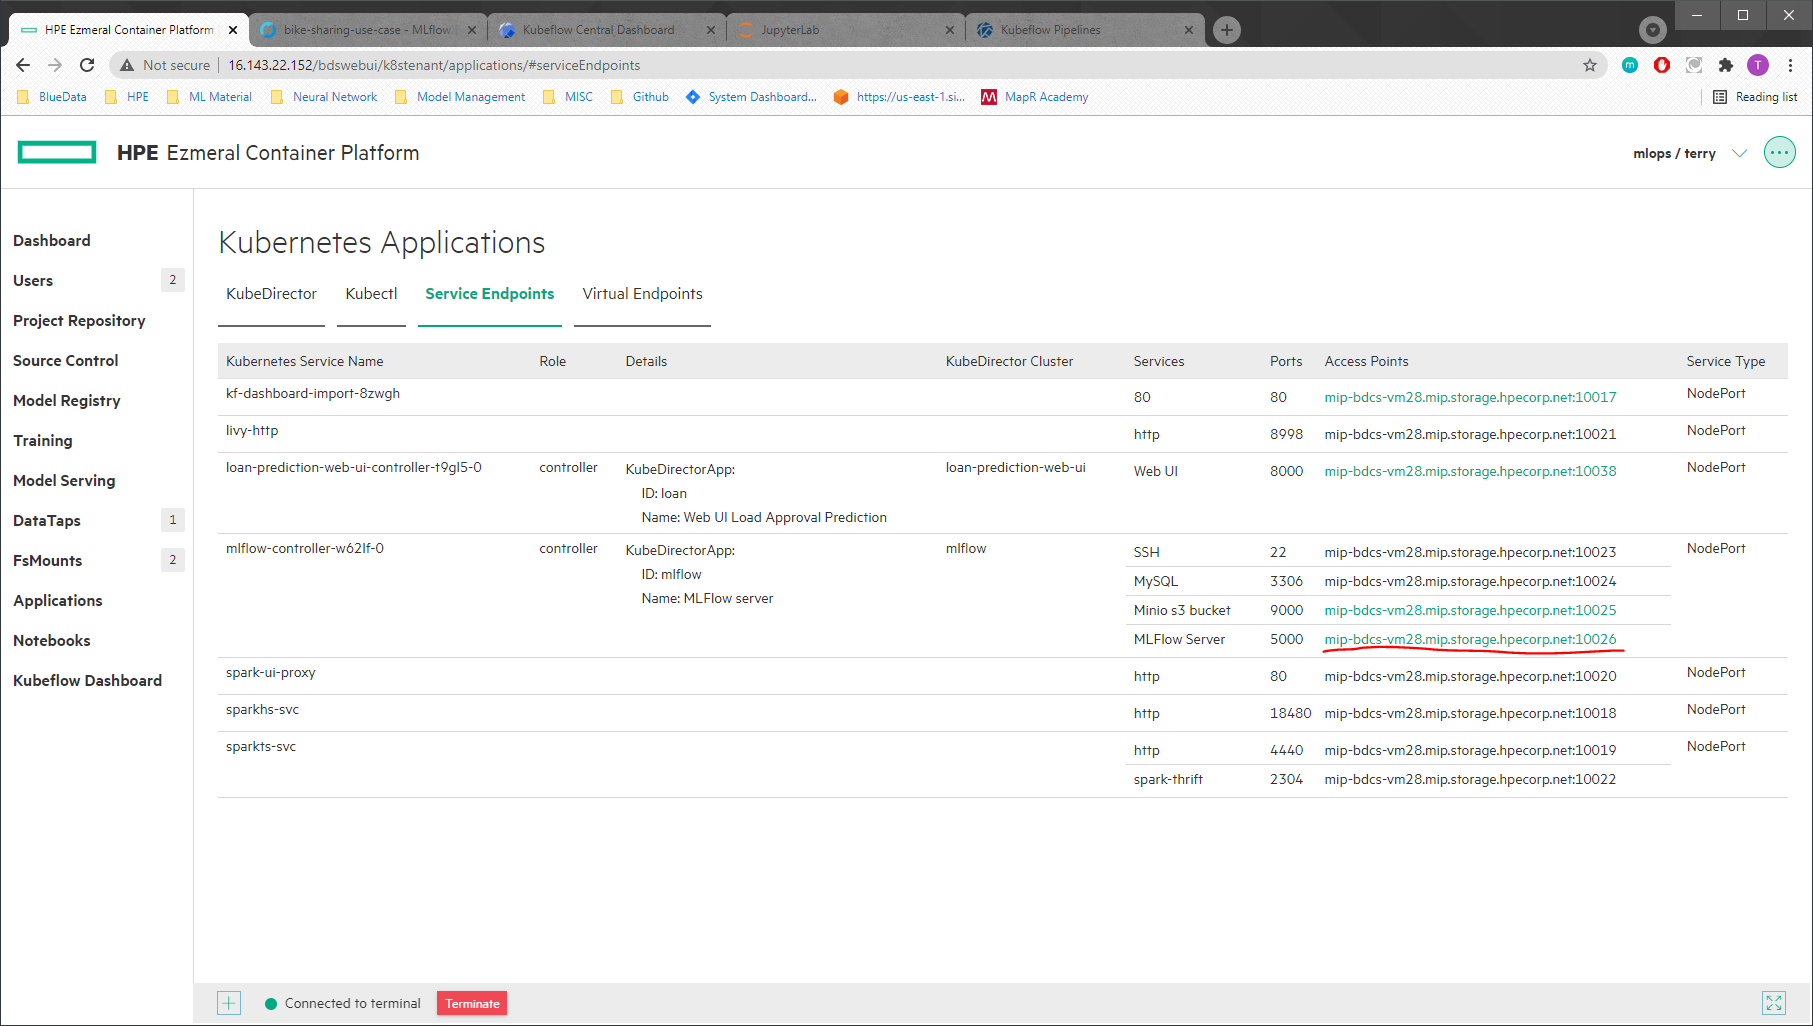

In [ ]:
best_run_df = mlflow.search_runs(order_by=['metrics.RMSE_CV ASC'], max_results=1)
if len(best_run_df.index) == 0:
    raise Exception(f"Found no runs for experiment '{experiment_name}'")

best_run = mlflow.get_run(best_run_df.at[0, 'run_id'])
best_model_uri = f"{best_run.info.artifact_uri}/model"
best_model = mlflow.sklearn.load_model(best_model_uri)

In [ ]:
# print best run info
print("Best run info:")
print(f"Run id: {best_run.info.run_id}")
print(f"Run parameters: {best_run.data.params}")
print("Run score: RMSE_CV = {:.4f}\n\n".format(best_run.data.metrics['RMSE_CV']))
print(f"Run model URI: {best_model_uri}")

In [ ]:
model_feature_importance(best_model)

In [ ]:
model_permutation_importance(best_model)

In [ ]:
# model_tree_visualization(best_model)

# Testing predictions 
Now that we have a trained model and we've sorted out the best one, we can test the prediction.
For simplicity, we will add a new column for predicted rented bikes to our dataset and create a visualization

In [ ]:
test_predictions = X_test.copy()
# real output (rented_bikes) from test dataset
test_predictions["rented_bikes"] = y_test

# add "predicted_rented_bikes" from test dataset
test_predictions["predicted_rented_bikes"] = best_model.predict(X_test).astype(int)

# show results
test_predictions

In [ ]:
# plot truth vs prediction values
test_predictions.plot(
    kind="scatter",
    x="rented_bikes",
    y="predicted_rented_bikes",
    title="Rented bikes vs predicted rented bikes",
    figsize=(15, 15),
)

## For the most part, the model seems to be performing well. Our visualization shows a linear distribution which is good to see. There are some outliers but its looking good overall. 
<br>


# Now let's continue onto Lab 4 for Serving!